In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [2]:
reviews_train = load_files('data/aclImdb/train/', categories=['pos', 'neg'])

In [3]:
text_train, y_train = reviews_train.data, reviews_train.target

In [4]:
reviews_test = load_files('data/aclImdb/test/', categories=['pos', 'neg'])

In [5]:
text_test, y_test = reviews_test.data, reviews_test.target

In [6]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in training data: 25000
[12500 12500]
Number of documents in test data: 25000
[12500 12500]


In [9]:
cv = CountVectorizer()
cv.fit(text_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [10]:
len(cv.vocabulary_)

74849

In [11]:
print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:50050])

['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m']
['pincher', 'pinchers', 'pinches', 'pinching', 'pinchot', 'pinciotti', 'pine', 'pineal', 'pineapple', 'pineapples', 'pines', 'pinet', 'pinetrees', 'pineyro', 'pinfall', 'pinfold', 'ping', 'pingo', 'pinhead', 'pinheads', 'pinho', 'pining', 'pinjar', 'pink', 'pinkerton', 'pinkett', 'pinkie', 'pinkins', 'pinkish', 'pinko', 'pinks', 'pinku', 'pinkus', 'pinky', 'pinnacle', 'pinnacles', 'pinned', 'pinning', 'pinnings', 'pinnochio', 'pinnocioesque', 'pino', 'pinocchio', 'pinochet', 'pinochets', 'pinoy', 'pinpoint', 'pinpoints', 'pins', 'pinsent']


In [12]:
X_train = cv.transform(text_train)
X_train

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

In [13]:
X_test = cv.transform(text_test)

In [14]:
%%time
logit = LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

CPU times: user 544 ms, sys: 0 ns, total: 544 ms
Wall time: 3.83 s


In [15]:
round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3)

(0.981, 0.864)

In [16]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");


In [17]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend();


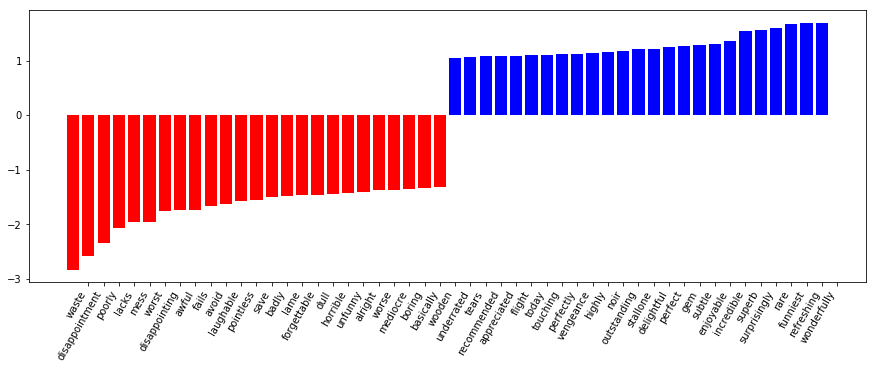

In [18]:
visualize_coefficients(logit, cv.get_feature_names())

In [19]:
from sklearn.pipeline import make_pipeline

In [20]:
%%time
text_pipe_logit = make_pipeline(CountVectorizer(),
                                # for some reason n_jobs > 1 won't work 
                                # with GridSearchCV's n_jobs > 1
                                LogisticRegression(solver='lbfgs', 
                                                   n_jobs=1,
                                                   random_state=7))

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))


/home/iii/opt/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.86428
CPU times: user 33.6 s, sys: 0 ns, total: 33.6 s
Wall time: 25.4 s


In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
%%time
param_grid_logit = {'logisticregression__C': np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1)

grid_logit.fit(text_train, y_train)

CPU times: user 23.7 s, sys: 0 ns, total: 23.7 s
Wall time: 2min


/home/iii/opt/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [23]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.1}, 0.88476)

/home/iii/opt/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


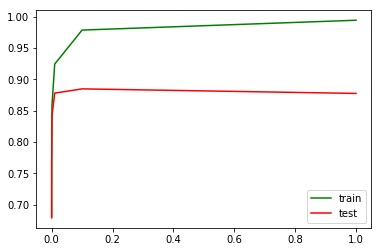

In [24]:
plot_grid_scores(grid_logit, 'logisticregression__C')

In [25]:
grid_logit.score(text_test, y_test)

0.87812

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
forest = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=17)

In [28]:
%%time
forest.fit(X_train, y_train)

CPU times: user 2min 34s, sys: 900 ms, total: 2min 35s
Wall time: 41.5 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [29]:
round(forest.score(X_test, y_test), 3)

0.855

In [30]:
# xor problem

In [31]:
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

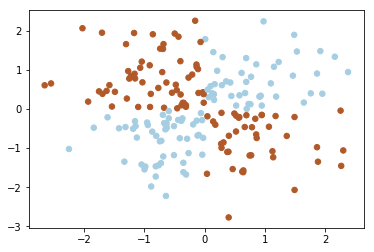

In [32]:
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)

In [33]:
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
    clf.fit(X, y)
    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(Z, interpolation='nearest',
                           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                           aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                               linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);


/home/iii/opt/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/iii/opt/anaconda3/envs/ML/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/iii/opt/anaconda3/envs/ML/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linetypes'
  s)


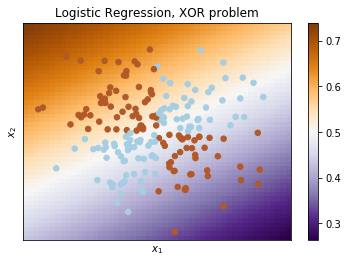

In [34]:
plot_boundary(LogisticRegression(), X, y, "Logistic Regression, XOR problem")

In [35]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [36]:
logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)), ('logit', LogisticRegression())])

/home/iii/opt/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/iii/opt/anaconda3/envs/ML/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/iii/opt/anaconda3/envs/ML/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linetypes'
  s)


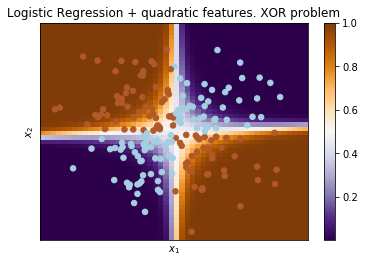

In [37]:
plot_boundary(logit_pipe, X, y, "Logistic Regression + quadratic features. XOR problem")